## *Prep*

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np

from collections import Counter

# The following five lines ensure that we reload the preprocessing functions 
# everytime this cell is called
import importlib
import helper_files.preprocessing as preprocFuncts
import helper_files.util as util
import parameters as MyParams
importlib.reload(preprocFuncts)
importlib.reload(util)
importlib.reload(MyParams)

# MODEL PARAMETERS

# DERIVATION PARAMETERS
WINDOW_LEN = MyParams.WINDOW_LEN # measured in IQ samples
OVERLAP = MyParams.OVERLAP
NUM_FEATURES = MyParams.NUM_FEATURES

# DATA PARAMETERS
TRAINING_DATA_DIR = MyParams.training_data_dir
EVAL_DATA_DIR = MyParams.eval_data_dir
NUM_TRAINING_FILES = MyParams.NUM_TRAINING_FILES # how many files in the saved numpy data for training
NUM_EVALUATION_FILES = MyParams.NUM_EVALUATION_FILES # how many files in the saved numpy data for evaluation
MAX_FILES = MyParams.MAX_FILES # if not using the saved numpy data, this is the max files to intake
USE_SAVED_DATA = MyParams.USE_SAVED_DATA # True = used the saved .npy file data instead of re-deriving the features again
SAVE_METRICS_TO_FILE = MyParams.SAVE_METRICS_TO_FILE
TRAINING_DATASET = MyParams.TRAINING_DATASET
EVAL_DATASET = MyParams.EVAL_DATASET

FEATURES_TO_USE = MyParams.FEATURES_TO_USE

## *Loading training dataset*

In [4]:
importlib.reload(preprocFuncts)
importlib.reload(util)
importlib.reload(MyParams)

print("Pulling from directory: ", TRAINING_DATA_DIR)

training_derived_samples, training_labels = preprocFuncts.preprocessFiles(
    TRAINING_DATA_DIR, 
    postfix=f"train_{NUM_FEATURES}ftrs_{NUM_TRAINING_FILES}files_{WINDOW_LEN}win_{'0' + str(int(OVERLAP * 100))}over{"_"+TRAINING_DATASET if TRAINING_DATASET != "" else ""}", 
    features_to_use=FEATURES_TO_USE,
    window_len=WINDOW_LEN,
    overlap=OVERLAP,
    saved_data=USE_SAVED_DATA, 
    max_files=MAX_FILES,
)

if (training_derived_samples.size <= 0):
    raise UserWarning("Array is empty") 

Pulling from directory:  /home/uav-cyberlab-rfml/RFML/test-dataset/test_dji_10mhz_chamber_training
Using the saved data:
	./saved-data/X_train_5ftrs_25files_4096win_050over_dji_10mhz_chamber.npy
	./saved-data/y_train_5ftrs_25files_4096win_050over_dji_10mhz_chamber.npy


## *Preprocessing training dataset*

The following cell removes labels that should not be used---like annotations that were not labeled, or the 'Burst' label, or the Ruko F11 pro labels because it does not appear in the evaluation dataset. 

The cell also applies an encoder to the labels to use for fitting and predicting.

In [5]:
print("\n==BEFORE BALANCING========")
util.display(training_derived_samples, training_labels)

training_derived_samples, training_labels = preprocFuncts.balanceByMedian(training_derived_samples, training_labels, unlabeled_downsampling=70_000)

print("\n==AFTER BALANCING========")
util.display(training_derived_samples, training_labels)



X_train = training_derived_samples
y_train = training_labels

print(f"Number of samples: {X_train.shape[0]:,}")
print(f"Number of labels: {len(y_train):,}")

remove_labels = [
    'Burst',
    '',
    'Ruko_F11_pro_UL',
]

# Build mask: True = keep, False = remove
mask = ~np.isin(y_train, remove_labels)

# Apply mask
X_train = X_train[mask]
y_train = y_train[mask]
y_train_strings = y_train

print(f"\nAfter removing unnecessary labels:")
print(f"Number of samples: {X_train.shape[0]:,}")
print(f"Number of labels: {len(y_train):,}")

le = LabelEncoder()
y_train = le.fit_transform(y_train)


==BEFORE BALANCING========

Number of labels: 190,700
Number of samples: 190,700

Shape of labels: (190700,)
Shape of samples: (190700, 5)

One sample: 
[2.1525155e+06 2.1477088e+06 1.7385825e+03 7.2146550e+13 5.8974518e+01]

The counts:
35,993   "Ocusync_2.0_mini_4k_DL"
5,732    "Ocusync_2.0_mini_4k_UL"
148,975  "background_noise"

==AFTER BALANCING========

Number of labels: 107,979
Number of samples: 107,979

Shape of labels: (107979,)
Shape of samples: (107979, 5)

One sample: 
[1.8779625e+02 1.9146814e+02 1.7123222e+01 6.3807898e+09 1.2941267e+03]

The counts:
35,993   "Ocusync_2.0_mini_4k_DL"
35,993   "Ocusync_2.0_mini_4k_UL"
35,993   "background_noise"
Number of samples: 107,979
Number of labels: 107,979

After removing unnecessary labels:
Number of samples: 107,979
Number of labels: 107,979


## *Loading evaluation dataset*

In [6]:
importlib.reload(preprocFuncts)
importlib.reload(util)
importlib.reload(MyParams)

print("Pulling from directory: ", EVAL_DATA_DIR)


test_derived_samples, test_labels = preprocFuncts.preprocessFiles(
    EVAL_DATA_DIR, 
    postfix=f"eval_{NUM_FEATURES}ftrs_{NUM_EVALUATION_FILES}files_{WINDOW_LEN}win_{'0' + str(int(OVERLAP * 100))}over{"_"+EVAL_DATASET if EVAL_DATASET != "" else ""}", 
    features_to_use=FEATURES_TO_USE,
    window_len=WINDOW_LEN,
    overlap=OVERLAP,
    saved_data=USE_SAVED_DATA, 
    max_files=MAX_FILES,
)

if (training_derived_samples.size <= 0):
    raise UserWarning("Array is empty") 

Pulling from directory:  /home/uav-cyberlab-rfml/RFML/test-dataset/test_dji_10mhz_chamber_eval
Using the saved data:
	./saved-data/X_eval_5ftrs_6files_4096win_050over_dji_10mhz_chamber.npy
	./saved-data/y_eval_5ftrs_6files_4096win_050over_dji_10mhz_chamber.npy


## *Preprocessing evaluation dataset*
First I need to remove labels that were in the evaluation set but not in the training set.

In [7]:
print("\n==BEFORE BALANCING========")
util.display(test_derived_samples, test_labels)

test_derived_samples, test_labels = preprocFuncts.balanceByMedian(test_derived_samples, test_labels, unlabeled_downsampling=7_000)
print("\n==AFTER BALANCING========")
util.display(test_derived_samples, training_labels)



X_test = test_derived_samples
y_test = test_labels

print(f"Number of samples: {X_test.shape[0]:,}")
print(f"Number of labels: {y_test.shape[0]:,}")

# remove labels that are in the y_test but not in y_train
remove_labels = np.setdiff1d(y_test, y_train_strings).tolist()
print(remove_labels)

# Build mask: True = keep, False = remove
mask = ~np.isin(y_test, remove_labels)

# Apply mask
X_test = X_test[mask]
y_test = y_test[mask]

print(f"\nAfter removing unnecessary labels:")
print(f"Number of samples: {X_test.shape[0]:,}")
print(f"Number of labels: {y_test.shape[0]:,}")

y_strings = y_test # store the string version of the labels before they get encoded
print("strings: ", X_test)


==BEFORE BALANCING========

Number of labels: 45,768
Number of samples: 45,768

Shape of labels: (45768,)
Shape of samples: (45768, 5)

One sample: 
[2.0735175e+02 2.0452408e+02 2.6430347e+01 1.4212313e+10 1.3687643e+03]



The counts:
8,623    "Ocusync_2.0_mini_4k_DL"
944      "Ocusync_2.0_mini_4k_UL"
36,201   "background_noise"

==AFTER BALANCING========

Number of labels: 107,979
Number of samples: 21,000

Shape of labels: (107979,)
Shape of samples: (21000, 5)

One sample: 
[2.3186410e+06 2.3253958e+06 1.9353157e+03 7.7929472e+13 5.1312519e+01]

The counts:
35,993   "Ocusync_2.0_mini_4k_DL"
35,993   "Ocusync_2.0_mini_4k_UL"
35,993   "background_noise"
Number of samples: 21,000
Number of labels: 21,000
[]

After removing unnecessary labels:
Number of samples: 21,000
Number of labels: 21,000
strings:  [[2.3186410e+06 2.3253958e+06 1.9353157e+03 7.7929472e+13 5.1312519e+01]
 [4.9048336e+07 4.6074888e+07 8.7488252e+03 1.5962344e+15 1.7516927e+03]
 [1.9550749e+02 2.0971027e+02 2.2526062e+01 1.0709362e+10 1.4224744e+03]
 ...
 [2.2954765e+06 2.3018545e+06 1.9220491e+03 7.7132730e+13 4.5666073e+01]
 [6.7935738e+05 6.7991844e+05 8.0121405e+02 2.2807889e+13 5.7553356e+01]
 [2.2797940e+06 2.2877515e+06 1.9349836

## *Fitting and prediction*

In [8]:
rf = RandomForestClassifier(n_estimators=200, random_state=123, class_weight="balanced")
rf.fit(X_train, y_train)
print(f"Fit ✔︎")

Fit ✔︎


In [9]:
y_test = le.transform(y_test)
y_pred = rf.predict(X_test)
print(f"Predicted ✔︎")

Predicted ✔︎


## *Metrics*

In [10]:
importlib.reload(preprocFuncts)
importlib.reload(util)

base_name = "rf"
model = "Random Forest"

accuracy = accuracy_score(y_test, y_pred)
perc_accuracy = accuracy * 100
cr = classification_report(y_test, y_pred, target_names=le.classes_)
cm = confusion_matrix(y_test, y_pred)

print(f"Model: {model}")
print(f"Accuracy: {perc_accuracy:.2f}%")
print(f"Max files: {MAX_FILES}\n\n")
print("Count\tLabel")
counts = Counter(y_strings)
for item, count in counts.items():
    print(f"{count}\t{item}")
print("")
print("Classification Report:")
print(f"{cr}")
print("Confusion Matrix:")
    
print(f"{cm}")

if SAVE_METRICS_TO_FILE:
    util.saveMetricsToFile(
        base_name=base_name + "_metrics", 
        model=model, 
        perc_accuracy=perc_accuracy, 
        notes="Using the fixed length sample size",
        cr=cr,
        cm=cm,
        labels=y_strings,
        max_files=MAX_FILES,
        window_size=WINDOW_LEN,
        overlap=OVERLAP,
        num_features = NUM_FEATURES,
        num_training_files = NUM_TRAINING_FILES,
        num_evaluation_files = NUM_EVALUATION_FILES,
    )

Model: Random Forest
Accuracy: 98.46%
Max files: 500


Count	Label
7000	Ocusync_2.0_mini_4k_UL
7000	Ocusync_2.0_mini_4k_DL
7000	background_noise

Classification Report:
                        precision    recall  f1-score   support

Ocusync_2.0_mini_4k_DL       0.99      1.00      0.99      7000
Ocusync_2.0_mini_4k_UL       0.97      0.99      0.98      7000
      background_noise       0.99      0.96      0.98      7000

              accuracy                           0.98     21000
             macro avg       0.98      0.98      0.98     21000
          weighted avg       0.98      0.98      0.98     21000

Confusion Matrix:
[[6996    0    4]
 [   0 6943   57]
 [  72  191 6737]]


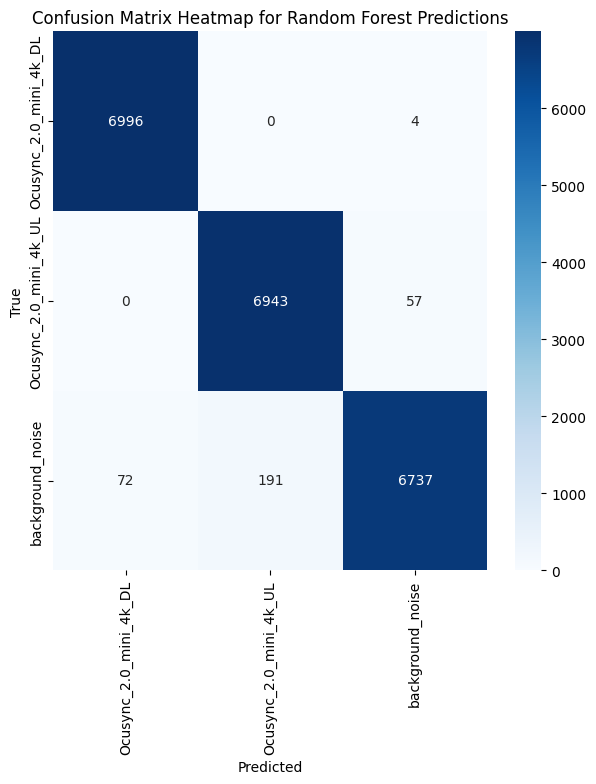

In [11]:
# Create a heatmap of the confusion matrix

plt.figure(figsize=(7, 7))
sn.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_strings), yticklabels=np.unique(y_strings))

# Labels and title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix Heatmap for {model} Predictions')

if SAVE_METRICS_TO_FILE:
    plt.savefig(f"./metrics/{base_name}_cm_{(perc_accuracy * 100):.0f}.png", bbox_inches='tight', dpi=200)
plt.show()


The following cell prints the important features. I need to fix this to be dynamic

['var_I', 'var_Q', 'mean_abs', 'total_power', 'spectral_bandwidth']


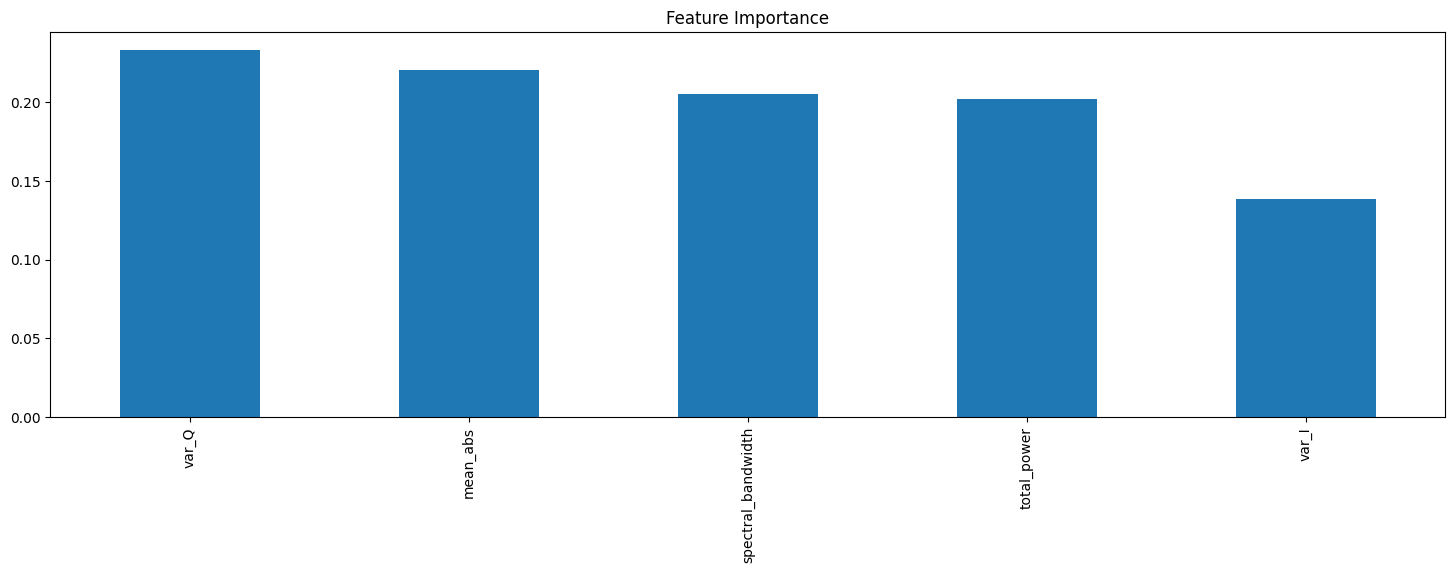

In [ ]:
import pandas as pd

features_to_use = []

for feature in FEATURES_TO_USE:
    if feature == "subbands":
        for band in range(64):
            features_to_use.append("subband " + str(band))
    else:
        features_to_use.append(feature)

features_to_use.remove("spectral_centroid")
print(features_to_use)

fi = pd.Series(rf.feature_importances_, index=features_to_use).sort_values(ascending=False)
fi.plot(kind='bar', figsize=(18,5), title="Feature Importance", fontsize=10)

if SAVE_METRICS_TO_FILE:
    plt.savefig(f"./metrics/{base_name}_fi_{(perc_accuracy * 100):.0f}.png", bbox_inches='tight', dpi=200)
plt.show()


The following cell prints Cohen's Kappa and Matthew's Correlation Coefficient
* Cohen's Kappa (κ) is a statistic measuring agreement between two categorical raters (or one rater at two times) beyond what's expected by chance, correcting for random agreement, and is used for inter-rater reliability in fields like machine learning. It ranges from -1 (total disagreement) to +1 (perfect agreement), with 0 meaning agreement is purely random.

* The Matthews Correlation Coefficient (MCC) is a robust metric in machine learning for evaluating binary/multiclass classification, measuring correlation between actual and predicted classes, ranging from -1 (perfect inverse) to +1 (perfect prediction), with 0 being random; it's especially valuable for imbalanced datasets as it uses all four confusion matrix values (TP, TN, FP, FN) for a balanced performance score, unlike simpler metrics that can be misleading.

In [ ]:
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import matthews_corrcoef

print("Cohen's Kappa:", cohen_kappa_score(y_test, y_pred))
print("MCC:", matthews_corrcoef(y_test, y_pred))


Cohen's Kappa: 0.9602002503128911
MCC: 0.9602821123088963
